In [5]:
import sys
sys.path.append("network/hvae")

from torch.nn.functional import interpolate
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms as T
from torchvision.datasets import FashionMNIST
from matplotlib import pyplot as plt
from network.hvae.oodd.losses import ELBO
import os
import typing as t
import gzip
import torch
import surprisenet.packnet as pn
from surprisenet.task_inference import TaskInferenceStrategy
from network.deep_vae import FashionMNISTDeepVAE
from tqdm import tqdm



plt.rcParams.update(
    {
        'font.family': 'Alegreya Sans',
        'font.size': 12,
        "image.cmap": "cividis"
    }
)


elbo_loss_func = ELBO()
MODEL_FILENAME = "/home/antonlee/github.com/tachyonicClock/SurpriseNetRun/SurpriseNet/experiment_logs/0000_pruneprop/0017_sweet-release.ecs.vuw.ac.nz_260c0626D_S-FMNIST-HVAE-EP_S-FMNIST_DeepVAE_surpriseNet/model.pt.gz"
ROOT="/local/scratch/antonlee/datasets/"
TASK_COMP = [
    [1,2],
    [9,5],
    [0,3],
    [4,7],
    [8,6],
]

In [11]:
# Load Model
from surprisenet.task_inference import HierarchicalVAEOOD

task_inference = HierarchicalVAEOOD(k=2)
model = pn.SurpriseNetDeepVAE(FashionMNISTDeepVAE(10), task_inference)
with gzip.open(MODEL_FILENAME, "rb") as f:
    model.load_state_dict(torch.load(f))

print(task_inference.k)

2


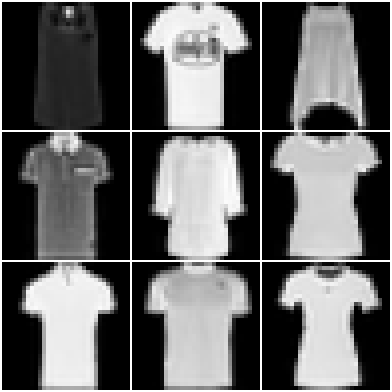

In [20]:
# Setup Dataset
def split_by_class(dataset: Dataset) -> t.List[Dataset]:
    """Split a dataset into a list of datasets, where each dataset contains only
    one class.
    """
    classes = set(map(int, dataset.targets))
    datasets = []
    for y in classes:
        indices = torch.where(dataset.targets == y)[0]
        datasets.append(Subset(dataset, indices))
    return datasets

def random_batch(dataset: Dataset, batch_size: int) -> t.Tuple[torch.Tensor, torch.Tensor]:
    """Return a random batch of `batch_size` from `dataset`
    """
    indices = torch.randperm(len(dataset))[:batch_size]
    x = torch.stack([dataset[i][0] for i in indices])
    y = torch.tensor([dataset[i][1] for i in indices])
    return x, y

def display_batch(x: torch.Tensor, scale: float = 4.0, rows: int = 3):
    """Display a batch of images in a grid
    """
    x = interpolate(x, scale_factor=scale, mode="nearest")
    image_grid = make_grid(x, nrow=rows, pad_value=1.0)
    return to_pil_image(image_grid)
    
transform = T.Compose([
    T.ToTensor(),
    T.Resize((32, 32), antialias=True),
])

joint_dataset = FashionMNIST(ROOT, train=False, transform=transform)
test_sets = split_by_class(joint_dataset)
display_batch(random_batch(test_sets[0], 9)[0])

In [103]:
from sklearn.manifold import TSNE

model.eval()
model.cuda()

active_task = 1
model.use_task_subset(active_task)




dataloader = DataLoader(joint_dataset, batch_size=100, shuffle=False)

# mean_stage_0 = []
# means_stage_1 = []
z_stage = []
with torch.no_grad():
    for x, y in tqdm(dataloader):
        x = x.cuda()
        likelihood, stage_data = model.wrapped.forward(x)

        # mean_stage_0.append(stage_data[0].q.mean)
        # means_stage_1.append(stage_data[1].q.mean)
        z_stage.append(stage_data[0].q.z)


# mean_stage_0 = torch.cat(mean_stage_0)
# means_stage_1 = torch.cat(means_stage_1)
z_stage = torch.cat(z_stage)


100%|██████████| 100/100 [00:06<00:00, 15.24it/s]


In [104]:
z_stage.shape

torch.Size([10000, 8, 16, 16])

In [105]:
# t-sne
tsne = TSNE(n_components=2, random_state=0)
print("Fitting t-sne")
numpy_z = z_stage.flatten(start_dim=1).detach().cpu().numpy()
z_2d = tsne.fit_transform(numpy_z)

Fitting t-sne


Text(0.5, 1.0, 't-sne Z (k=2) subset 1 just saw [9, 4]')

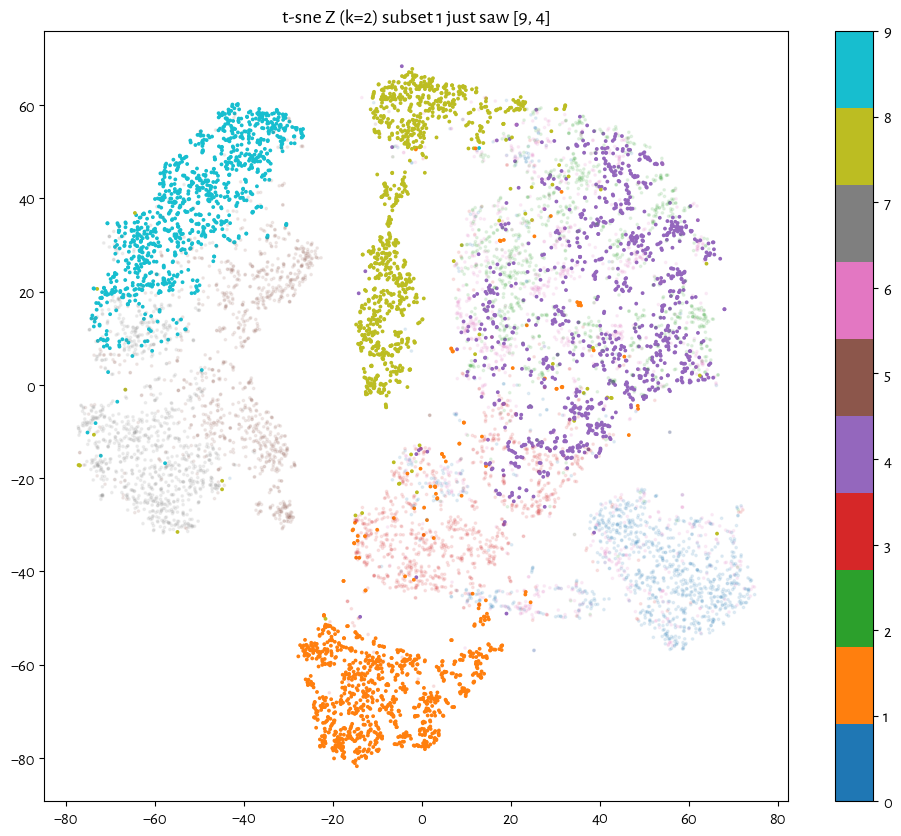

In [106]:
# plot
plt.figure(figsize=(12, 10))

seen_indices = torch.tensor([], dtype=torch.long)
for composition in TASK_COMP[:active_task+1]:
    for class_label in composition:
        seen_indices = torch.cat([seen_indices, torch.where(joint_dataset.targets == class_label)[0]])

# seen_indices to determine alpha
alpha = torch.ones(len(joint_dataset)) * 0.1
alpha[seen_indices] = 1.0



plt.scatter(
    z_2d[:, 0], z_2d[:, 1], 
    c=joint_dataset.targets,
    alpha=alpha,
    cmap="tab10",
    s=3.0)
plt.colorbar()
plt.title(f"t-sne Z (k=2) subset {active_task} just saw {TASK_COMP[active_task]}")

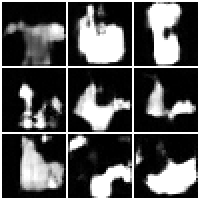

In [6]:
model.eval()
model.use_task_subset(4)
display_batch(model.generate(9), scale=2)

In [44]:
import seaborn as sns


model.cuda().eval()


novelty_scores: t.Dict[int, t.List[torch.Tensor]] = {}

for subset in range(5):
    novelty_scores[subset] = []

    for label, test_set in enumerate(test_sets):
        dataloader = DataLoader(test_set, batch_size=256, shuffle=False)

        novelty = torch.tensor([], dtype=torch.float32)
        model.use_task_subset(subset)
        for x, y in tqdm(dataloader):
            novelty = torch.cat((novelty, task_inference._novelty_score(x.cuda()).cpu()))
    
        novelty_scores[subset].append(novelty)


100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


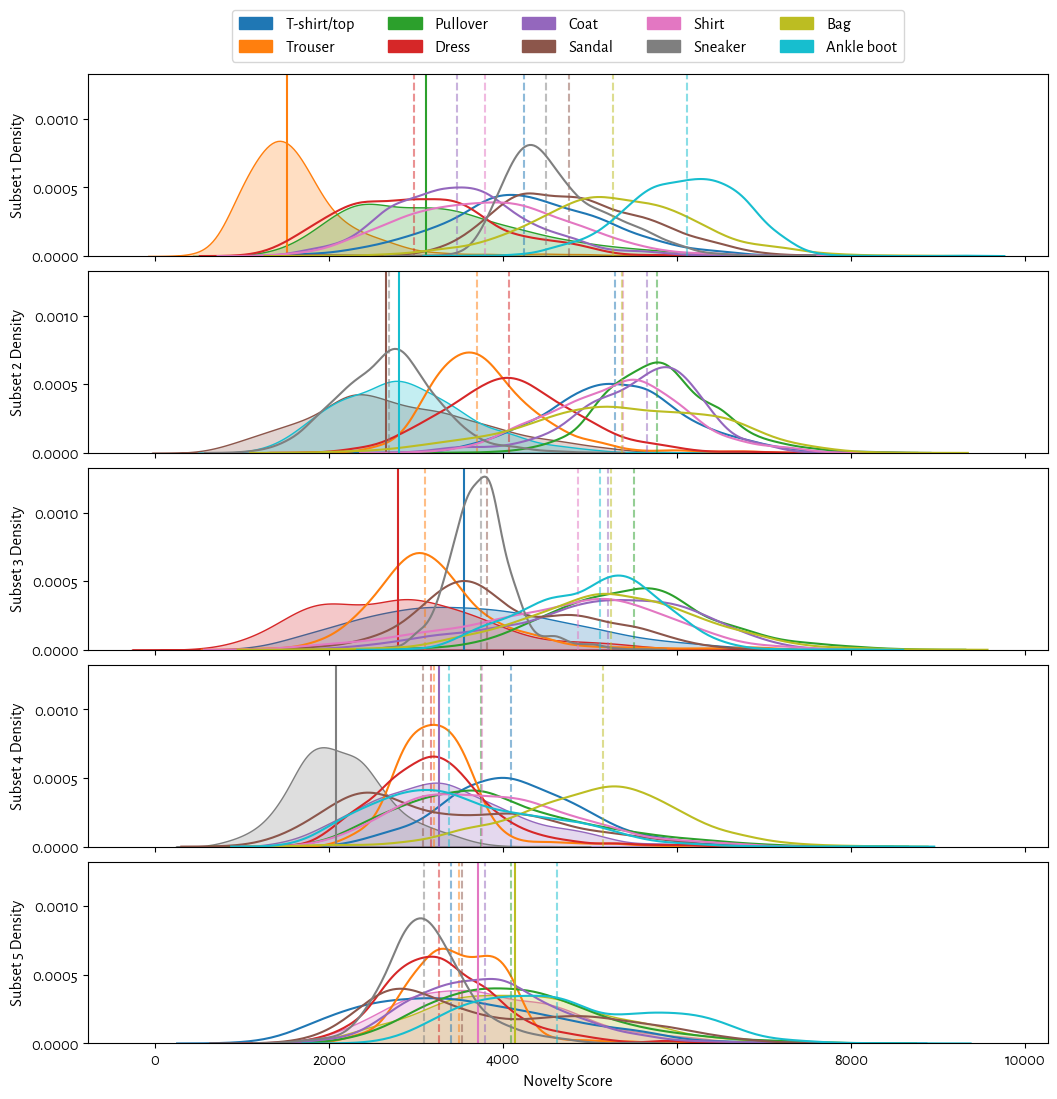

In [101]:

# Subplots
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as mpatches



fig, axes = plt.subplots(5, 1, figsize=(10, 2*5), sharex=True, sharey=True)
# Remove padding

# flattent axes
axes = axes.flatten()

for subset, class_novelty in novelty_scores.items():
    for class_label, novelty in enumerate(class_novelty):
        in_task = class_label in TASK_COMP[subset]
        
        sns.kdeplot(novelty, label=f"{label} {subset}", ax=axes[subset], fill=in_task, color=f"C{class_label}")

        if in_task:
            axes[subset].axvline(novelty.median(), color=f"C{class_label}", linestyle="-")
        else:
            axes[subset].axvline(novelty.median(), color=f"C{class_label}", linestyle="--", alpha=0.5)

    

    
    axes[subset].set_ylabel(f"Subset {subset+1} Density")


# Change y axis units
for ax in axes:
    ax.set_xlabel("Novelty Score")

# Legend
patches = [mpatches.Patch(color=f'C{i}', label='The red data') for i in range(10)]

# fashion mnist labels
fmnist_label = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]


axes[0].legend(patches, fmnist_label, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.4))


In [7]:
from tqdm import tqdm
model.cuda()
model.eval()

class_task_count = torch.zeros(10, 5)

with torch.no_grad():
    for class_label, test_set in enumerate(test_sets):
        dataloader = DataLoader(test_set, batch_size=100, shuffle=False)

        print("Testing on class", class_label)
        for x, y in tqdm(dataloader):
            x = x.cuda()
            out = model.multi_forward(x)
            for subset_pred in out.pred_exp_id:
                class_task_count[class_label, subset_pred] += 1


Testing on class 0


100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


Testing on class 1


100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


Testing on class 2


100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


Testing on class 3


100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


Testing on class 4


100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


Testing on class 5


100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


Testing on class 6


100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


Testing on class 7


100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


Testing on class 8


100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


Testing on class 9


100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


In [8]:
task_confusion = torch.zeros(5, 5)

for true_task, composition in enumerate(TASK_COMP):
    for class_label in composition:
        task_confusion[true_task] += class_task_count[class_label]
task_confusion

tensor([[1754.,    7.,   11.,  160.,   68.],
        [  25., 1633.,    2.,  328.,   12.],
        [ 392.,   14.,  746.,  295.,  553.],
        [ 353.,   91.,    6., 1481.,   69.],
        [ 513.,   61.,  104.,  316., 1006.]])

tensor(0.6620)

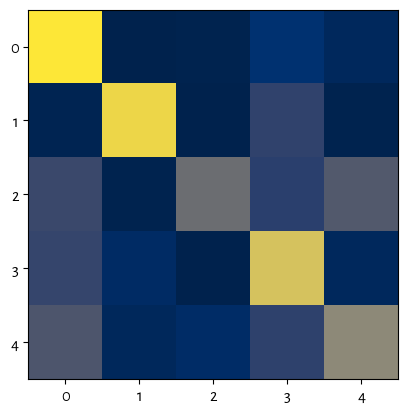

In [9]:


plt.imshow(task_confusion)

# What percentage lies on the diagonal?
task_confusion.diag().sum() / task_confusion.sum()